# Homework 2 -Paul Kreymborg

Worked with Alex Thomas, Dylan Herman, Gabby Carrel, Kyle Lam, Sabrina Brickner, Sarah Webster,  Sam Whitebook, Zoe Xing.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats #used to find p-value from z-score
plt.style.use('phys240.mplstyle')

# Problem 1: Creating Figures

The EDGES experiment is searching for a signal of the cosmic dawn, when the first stars turned on. The expected signal is a small drop in the brightness of the radio sky at a frequency of around 80 MHz. The problem is that this drop is about $10^{−4}$ of the foreground at that frequency. The foreground is composed of emission by the sky and by synchrotron radiation from free electrons in the Galaxy. In this problem set, you will analyze data from the EDGES experiment yourself to constrain the cosmic dawn. The data file provided includes the sky temperature as a function of frequency. The original paper is available at
https://www.nature.com/articles/nature25792 .

**Part a.** I will define $\nu$ to be the frequency divided by the central frequency of observations, i.e., 75 MHz; ν is
then dimensionless. The published paper fit the sky temperature using the following model:
\begin{equation}
T[ν] \approx a_0\nu^{−2.5} + a_1\nu^{-2.5}\log\nu + a_2\nu^{-2.5}(\log\nu)^2 + a_3\nu^{-4.5} + a_4\nu^{-2}.
\end{equation}
Perform this fit yourself using least-squares (SVD) with unit weights for each point ($\sigma^2$ is a constant independent of $\nu$) and plot the residuals. This should match Figure 1 of the paper exactly.

**Solution a.**
First, we define a Python method to give us the $f_i(\nu)$ that we multiply with coefficients $a_i$ to get our model $T[\nu]$

In [3]:
import numpy as np
import scipy.optimize

def linear_fi_funcs(v):
    return np.array([
        np.power(v,-2.5),
        np.power(v,-2.5)*np.log(v),
        np.power(v,-2.5)*np.square(np.log(v)),
        np.power(v,-4.5),
        np.power(v,-2),
    ])

We can use SVD with unit weights for error, trying to fit our parameters $\bf{x}$ as close as possible to the equation that predicts our temperature measurements $\bf{b}$
\begin{equation}
\bf{A}\bf{x}=\bf{b}
\end{equation}
It may not be possible to exactly match our data, but we can minimize our model's squared residual,
\begin{equation}
\vert\vert\bf{A}\bf{x}-\bf{b}\vert\vert
\end{equation}
Our matrix $\bf{A}$ and vectors $\bf{x}$ and $\bf{b}$ are defined:
\begin{equation}
\bf{A} = \begin{pmatrix}
f_0(\nu_1) & f_1(\nu_1) & f_2(\nu_1) & f_3(\nu_1) & f_4(\nu_1) \\
f_0(\nu_2) & f_1(\nu_2) & f_2(\nu_2) & f_3(\nu_2) & f_4(\nu_2) \\
\vdots & \vdots & \vdots & \vdots & \vdots \\
\end{pmatrix}
\end{equation}
\begin{equation}
\bf{x} = \begin{pmatrix}
a_0 \\
a_1 \\
a_2 \\
a_3 \\
a_4 \\
\end{pmatrix}
\end{equation}
\begin{equation}
\bf{b} = \begin{pmatrix}
T_1 \\
T_2 \\
\vdots \\
\end{pmatrix}
\end{equation}
We can construct A in Numpy from the measured frequencies:

In [4]:
def A_mat_from_freqs(v_measurements):
    return linear_fi_funcs(v_measurements).T

We read the frequencies $\nu_i$ and temperatures $T_i$ from the data file:

In [5]:
def read_data():
    with open("skytemperature.dat") as f:
        freqs_measured = []
        temps_measured = []
        for line in list(f)[1:]:
            if len(line.rstrip()) == 0:
                continue

            F,T = line.rstrip().split()
            freqs_measured.append(float(F))
            temps_measured.append(float(T))
        freqs_measured = np.array(freqs_measured)
        temps_measured = np.array(temps_measured)
    return freqs_measured, temps_measured

freqs_measured,temps_measured = read_data()

Next, we calculate $\bf{A}$ from the measured frequencies, and decompose it with SVD:
\begin{equation}
\bf{A}=\bf{U}\bf{W}\bf{V}^T
\end{equation}
We then calculate the "inverse" of W and use it to calculate the best fit for $\bf{x}$, which is our best parameters $a_i$:

Best fit for a parameters: [-1.36918812e+09  6.86145273e+08 -1.25797001e+08  5.47052781e+10
  9.55221483e+07]


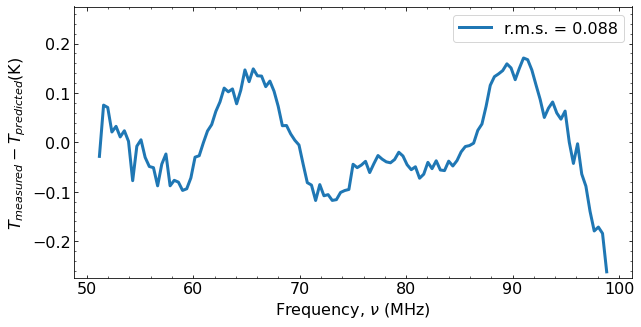

In [124]:
def linear_analysis():
    A = A_mat_from_freqs(freqs_measured)
    U,Wvals,VT = np.linalg.svd(A)
    Winv = 1/Wvals
    threshold = 1e-14
    Winv[Wvals < threshold*np.amax(Wvals)] = 0
    Winv_full = np.zeros(A.T.shape,dtype=Winv.dtype)
    Winv_full[:len(Wvals),:len(Wvals)] = np.diag(Winv)
    abest = np.linalg.multi_dot([VT.T,Winv_full,U.T,temps_measured])
    return abest

def plot_residuals(predicted_T,labels=None):
    predicted_T = np.array(predicted_T)
    residual = temps_measured - predicted_T
    max_error = np.max(np.abs(residual))

    res_rms = np.sqrt(np.mean(np.power(residual,2)))
    fig, ax = plt.subplots(figsize=(10,5))
#    ax.plot(freqs_measured,np.zeros(residual.shape),"--",color="dimgray",linewidth=1.5)
    ax.plot(freqs_measured,residual,"C0",label="r.m.s. = {0:.2g}".format(res_rms))

    ax.set_xlabel(r'Frequency, $\nu$ (MHz)')
    ax.set_ylabel(r'$T_{measured}-T_{predicted}$(K)')
    ax.set_ylim([-max_error*1.05,max_error*1.05])
    ax.legend()



lin_fit_best_a = linear_analysis()
print("Best fit for a parameters: {}".format(lin_fit_best_a))
linear_predicted_T = linear_fi_funcs(freqs_measured).T @ lin_fit_best_a
plot_residuals(linear_predicted_T)

**Part b.**
The model that you fit in Part (a) is a linearization of a more physically motivated model,
\begin{equation}
T[\nu] = b_0 \nu^{-2.5+b_1+b_2\log\nu}e^{-b_3\nu^{-2}}+b_4\nu^{-2} \tag{2}
\end{equation}
Perform the nonlinear fit using the optimization routine of your choice (check out <tt>scipy.optimize.minimize</tt>
or <tt>scipy.optimize.curve_fit)</tt>. Verify that you closely reproduce the residuals from Part (a).

**Solution b.** We can define the non-linear model function with python, and fit starting with parameters found manually that come close to the solution.

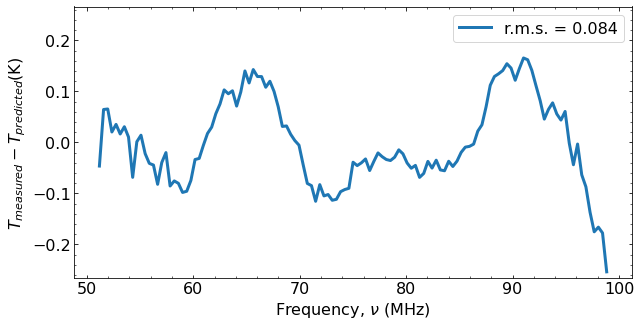

In [125]:

def nonlinear_model_t(v,b0,b1,b2,b3,b4):
    first_exponent = -2.5 + b1 + b2 * np.log(v)
    second_exponent = -b3 * 1/(v*v)
    
    t = b0*np.power(v,first_exponent) * np.exp(second_exponent) + b4*np.power(v,-2)
    #print(t)
    return t

def nonlinear_analysis():
    pstart = [600,6,-0.8,-700,5000000]
    pbest, pcov = scipy.optimize.curve_fit(
        nonlinear_model_t,freqs_measured,temps_measured,
        p0=pstart,
        maxfev=10000
    )
    pred_t = [nonlinear_model_t(freq,*pbest) for freq in freqs_measured]
    return pred_t


nonlinear_model_pred_T = nonlinear_analysis()
plot_residuals(nonlinear_model_pred_T)


**Part c.** It is often possible to make an optimization problem much, much simpler with a bit of cleverness, and Part (b) is a great example. Subtract $b_4\nu^{-2}$ from each side, multiply both sides by $\nu^{2.5}$, and take the logarithm. You should see that the fit is now linear in all variables except for $b_4$. To maintain the same weights for each point as before, you should set
\begin{equation}
\sigma_\nu^2 \propto \left(\frac{d\log[T-b_4\nu^{-2}]}{dT}\right)^2 = \frac{1}{(T-b_4\nu^{-2})^2}. \tag{3}
\end{equation}
Use least-squares/SVD to optimize the solution at each trial $b_4$, and solve the 1-D nonlinear optimization using the method of your choice. Plot your residuals, and verify that they look almost the same as for Part (a) and, hopefully, identical to Part (b). Your fit should be very slightly better than you got for Part (a) as measured by $\chi^2$.

**Solution c.**
If we subtract $b_4\nu^{-2}$ from both sides, multiply by $\nu^{2.5}$ and take the natural log:
\begin{equation}
T[\nu] = b_0 \nu^{-2.5+b_1+b_2\log\nu}e^{-b_3\nu^{-2}}+b_4\nu^{-2}
\end{equation}
\begin{equation}
T[\nu] - b_4\nu^{-2} = b_0 \nu^{-2.5+b_1+b_2\log\nu}e^{-b_3\nu^{-2}}
\end{equation}
\begin{equation}
\left(T[\nu] - b_4\nu^{-2}\right)\nu^{2.5} = b_0 \nu^{b_1+b_2\log\nu}e^{-b_3\nu^{-2}}
\end{equation}
\begin{equation}
\log\left(\left(T[\nu] - b_4\nu^{-2}\right)\nu^{2.5}\right) = \log\left(b_0 \nu^{b_1+b_2\log\nu}e^{-b_3\nu^{-2}}\right)
\end{equation}
\begin{equation}
\log\left(T[\nu] - b_4\nu^{-2}\right) + 2.5\log\left(\nu\right) = \log\left(b_0\right) + \left(b_1 + b_2\log\nu\right) \log\nu -b_3\nu^{-2}
\end{equation}
\begin{equation}
\log\left(T[\nu] - b_4\nu^{-2}\right) + 2.5\log\left(\nu\right) = b_{0,log} + b_1\log\nu + b_2\left(\log\nu\right)^2  -b_3\nu^{-2}
\end{equation}

We construct $\bf{A}\bf{x} \approx \bf{b}$ to minimize error, with our error $\sigma_i=\sigma_\nu(\nu_i)$ included:
\begin{equation}
\bf{A} = \begin{pmatrix}
g_0(\nu_1)/\sigma_1 & g_1(\nu_1)/\sigma_1 & g_2(\nu_1)/\sigma_1 & g_3(\nu_1)/\sigma_1 \\
g_0(\nu_2)/\sigma_2 & g_1(\nu_2)/\sigma_2 & g_2(\nu_2)/\sigma_2 & g_3(\nu_2)/\sigma_2  \\
\vdots & \vdots & \vdots & \vdots & \vdots \\
\end{pmatrix}
\end{equation}
\begin{equation}
\bf{b} = \begin{pmatrix}
\left(\log\left(T_1 - b_4\nu_1^{-2}\right) + 2.5\log\left(\nu_1\right)\right)/\sigma_1\\
\left(\log\left(T_2 - b_4\nu_2^{-2}\right) + 2.5\log\left(\nu_2\right)\right)/\sigma_2\\
\vdots \\
\end{pmatrix}
\end{equation}
Where
\begin{equation}
g_0(\nu) = 1, g_1(\nu)=\log\nu, g_2(\nu)=\left(\log\nu\right)^2, g_3(\nu)=-\nu^{-2}
\end{equation}

We use numpy to optimize ${b_{0,log}}$,${b_1}$,${b_2}$,${b_3}$ for any given ${b_4}$, and then we just use scipy to curve fit for the {b_4} parameter:

best fit b0,b1,b2,b3,b4:
572.9970432122627,5.557981304544228,-0.6945604825735643,-702.4181921263225,5129449.653750323


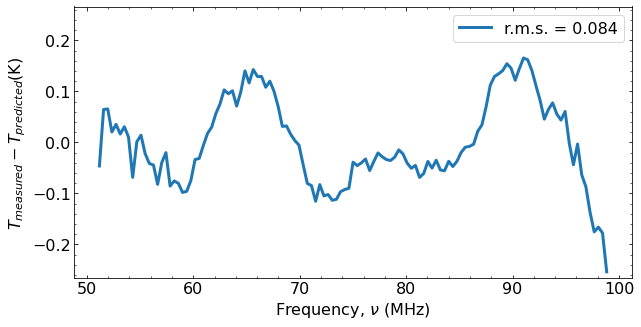

In [126]:
#def log_t_minus_b4term(v,b4):
def mixed_analysis_g_funcs(v):
    return np.array([
        np.ones(v.shape),
        np.log(v),
        np.square(np.log(v)),
        -np.power(v,-2)
    ])

def mixed_analysis_b_meas_errs(b4):
    thingy = (temps_measured-b4/np.square(freqs_measured))
    if thingy.min() <= 0:
        raise Exception("b4 is too big, {}".format(b4))
    return 1/np.abs(thingy)

def a_matrix_mixed_analysis(b4):
    g_funcs_for_freqs = mixed_analysis_g_funcs(freqs_measured).T

    errs_for_freqs = mixed_analysis_b_meas_errs(b4)

    element_errors = np.tile(errs_for_freqs,(4,1)).T
    
    return g_funcs_for_freqs/element_errors

def target_b_mixed_analysis(b4):
    data_vals = np.log(temps_measured-b4/np.square(freqs_measured)) + 2.5*np.log(freqs_measured)
    errs_for_freqs = mixed_analysis_b_meas_errs(b4)
    
    return (data_vals/errs_for_freqs).T

def best_params_for_b4(b4):
    A = a_matrix_mixed_analysis(b4)
    b = target_b_mixed_analysis(b4)
    
    U, W, VT = np.linalg.svd(A)
    Winv = 1/W
    threshold = 1e-14
    Winv[W < threshold*np.amax(W)] = 0
    Winv_full = np.zeros(A.T.shape)
    Winv_full[:len(W), :len(W)] = np.diag(Winv)
    alpha = VT.T @ Winv_full @ U.T @ b
    
    b0 = np.exp(alpha[0])
    b1 = alpha[1]
    b2 = alpha[2]
    b3 = alpha[3]
    return b0,b1,b2,b3

def mixed_model_t(v,b4):
    b0,b1,b2,b3 = best_params_for_b4(b4)
    return b0*np.power(v, -2.5 + b1 + b2 * np.log(v) ) * np.exp(-b3/np.square(v)) + b4/np.square(v)

def mixed_analysis():
    popt,pcov = scipy.optimize.curve_fit(mixed_model_t,freqs_measured,temps_measured,p0=[5e6])
    b4_best = popt[0]
    b0_best,b1_best,b2_best,b3_best = best_params_for_b4(b4_best)
    pred_t = mixed_model_t(freqs_measured,b4_best)
    print("best fit b0,b1,b2,b3,b4:")
    print("{},{},{},{},{}".format(b0_best,b1_best,b2_best,b3_best,b4_best))
    return pred_t
    
nonlinear_with_svd_pred_T = mixed_analysis()
plot_residuals(nonlinear_with_svd_pred_T)

We can compare all three models and see that the non-linear models, which converge to the same parameters, give a better fit than the linear model:

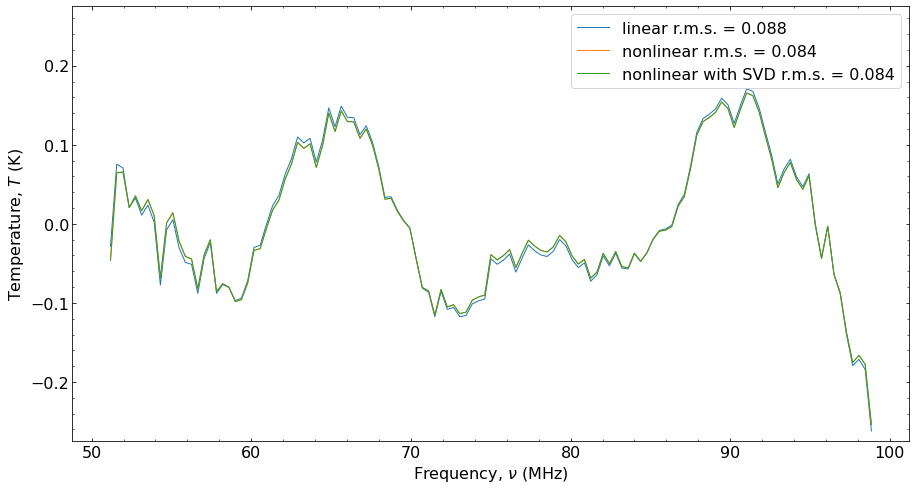

In [127]:

def compare_residuals():
    lin_res = temps_measured - linear_predicted_T
    nonlin_res = temps_measured - nonlinear_model_pred_T
    nonlin_svd_res = temps_measured - nonlinear_with_svd_pred_T
    
    lin_rms = np.sqrt(np.mean(np.square(lin_res)))
    nonlin_rms = np.sqrt(np.mean(np.square(nonlin_res)))
    nonlin_svd_rms = np.sqrt(np.mean(np.square(nonlin_svd_res)))
    
    max_error = max(np.abs(lin_res).max(),np.abs(nonlin_res).max(),np.abs(nonlin_svd_res).max())
    
    fig, ax = plt.subplots(figsize=(15,8))
#    ax.plot(freqs_measured,np.zeros(residual.shape),"--",color="dimgray",linewidth=1.5)
    ax.plot(freqs_measured,lin_res,label="linear r.m.s. = {0:.2g}".format(lin_rms),linewidth=1)
    ax.plot(freqs_measured,nonlin_res,label="nonlinear r.m.s. = {0:.2g}".format(nonlin_rms),linewidth=1)
    ax.plot(freqs_measured,nonlin_svd_res,label="nonlinear with SVD r.m.s. = {0:.2g}".format(nonlin_svd_rms),linewidth=1)

    ax.set_xlabel(r'Frequency, $\nu$ (MHz)')
    ax.set_ylabel(r'Temperature, $T$ (K)')
    ax.set_ylim([-max_error*1.05,max_error*1.05])
    ax.legend()

compare_residuals()
    

# Problem 2: 80MHz Temperature Dip 

Light from the first stars is expected to cause a small dip in $T$ around an unknown frequency, very roughly 80 MHz (don’t worry about the basic physics reason why if you don’t want to, but feel free to ask!). The published paper fit a flattened Gaussian and reported a central frequency of 78 MHz, a width of around 15 MHz, and an amplitude of 0.5 K. It reported a very high signal-to-noise ratio and small errors. In this part, you will reproduce this result and then do a series of more rigorous fits to judge its reliability.

**Part a.** Begin by adding the following function to your fit (not quite what is in the paper, but close and easier
to write):
\begin{equation}
c_0\exp\left[-\left|\frac{v-c_1}{c_2}\right|^5\right]. \tag{4}
\end{equation}
For now you may stick with the polynomial model from Part (a); it will make the fitting a bit easier. Find the best-fit $c_0$ and $c_1$, and compare your amplitude with the published 0.53 K and 78 MHz (dimensionless $\nu = 1.04$). Also, compare your root-mean-square residuals with the published value of 25 mK. Hint: the model is linear in all but two parameters.

**Solution a.**
Since the model is linear in all the parameters except $c_1$ and $c_2$, we can use SVD to find the best parameters $a_0$, $a_1$, $a_2$, $a_3$, $a_4$, $c_0$ for a given $c_1$, $c_2$, and use curve fitting on just the two parameteers $c_1$ and $c_2$:

<ipython-input-128-4b8ec1933f16>:20: RuntimeWarning: divide by zero encountered in true_divide
  Winv = 1/W


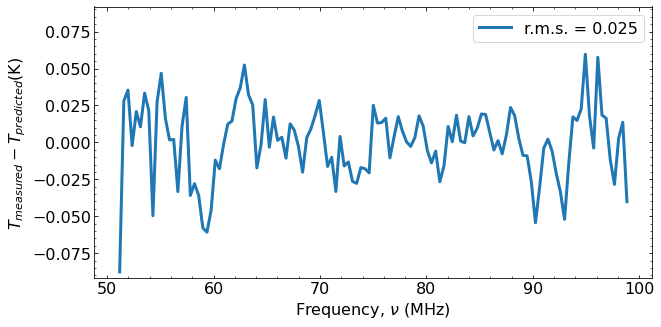

In [128]:
# Return the coefficients for all our linear parameters.
# Last item is exp[-abs((v-c1)/c2)^5], which is the coefficient on c0

def temp_dip_func_array(unnorm_v, c1,c2):
    percent_v = unnorm_v/100
    return np.array([
        np.power(percent_v,-2.5),
        np.power(percent_v,-2.5)*np.log(percent_v),
        np.power(percent_v,-2.5)*np.square(np.log(percent_v)),
        np.power(percent_v,-4.5),
        np.power(percent_v,-2),
        np.exp( -np.power(np.abs( (percent_v-c1)/c2 ), 5) ),
    ])

def temp_dip_best_lin_params(c1,c2):
    A = temp_dip_func_array(freqs_measured,c1,c2).T
    B = temps_measured.T
    
    U, W, VT = np.linalg.svd(A)
    Winv = 1/W
    threshold = 1e-14
    Winv[W < threshold*np.amax(W)] = 0
    Winv_full = np.zeros(A.T.shape)
    Winv_full[:len(W), :len(W)] = np.diag(Winv)
    alpha = VT.T @ Winv_full @ U.T @ B

    a0,a1,a2,a3,a4,c0 = alpha

    return a0,a1,a2,a3,a4,c0

def temp_dip_pred_t_from_c1_c2(v,c1,c2):
    a0,a1,a2,a3,a4,c0 = temp_dip_best_lin_params(c1,c2)
    return np.array([a0,a1,a2,a3,a4,c0]) @ temp_dip_func_array(v,c1,c2)

def temp_dip_analysis():
    try_c1_vals = np.linspace(0.1,1,50)
    try_c2_vals = np.linspace(0.01,0.3,60)
    
    best_c1_overall = None
    best_c2_overall = None
    best_rms_overall = None
    
    for start_c1 in try_c1_vals:
        for start_c2 in try_c2_vals:
            #print("Trying c1,c2={},{}".format(start_c1,start_c2))
            popt,pcov = scipy.optimize.curve_fit(
                temp_dip_pred_t_from_c1_c2,
                freqs_measured,
                temps_measured,
                p0=[start_c1,start_c2],
                bounds=(
                    [0,0],
                    [1,0.3]
                ),
                maxfev=1000)
            c1_best,c2_best = popt
            #a0_best,a1_best,a2_best,a3_best,a4_best,c0_best = temp_dip_best_lin_params(c1_best,c2_best)
            pred_t = temp_dip_pred_t_from_c1_c2(freqs_measured,c1_best,c2_best)
            rms = np.sqrt(np.mean(np.square(pred_t - temps_measured)))
            if best_rms_overall is None or rms < best_rms_overall:
                best_c1_overall = c1_best
                best_c2_overall = c2_best
                best_rms_overall = rms
    return best_c1_overall, best_c2_overall

best_c1_overall,best_c2_overall = temp_dip_analysis()
a0_best,a1_best,a2_best,a3_best,a4_best,c0_best = temp_dip_best_lin_params(best_c1_overall,best_c2_overall)
temp_dip_predicted_T = temp_dip_pred_t_from_c1_c2(freqs_measured,best_c1_overall,best_c2_overall)

plot_residuals(temp_dip_predicted_T)


In [129]:
print("Best c0,c1,c2:")
print("{}, {}, {}".format(c0_best,best_c1_overall,best_c2_overall))

Best c0,c1,c2:
-0.4990519135532878, 0.7825519185159661, 0.10035803203586494


As we see, after compensating for our normalizing $\nu$ to $\nu/$100MHz, the parameter $c_1\approx0.7825$ tells us the light is observed to fall at about 78 MHz, and the parameter $c_0\approx-0.499$ gives a dip amplitude of 0.5K. This is close to the paper's dip with frequency 78 Mhz and amplitude 0.53K - The reason for the different amplitude might be that our exponential function is shaped different.

**Part b.** If you take the error on each measurement to be 25 mK (and uncorrelated), compute $\chi^2$ before and after fitting this extra component. Then compute the best-fit $\chi^2$ as a function of $c_0$, holding $c_0$ fixed at a range of possible values and varying all of the other parameters to optimize $\chi^2$ at each trial $c_0$. The 1-$\sigma$ interval is approximately the range of $c_0$ for which $\chi^2 \leq \chi_\text{min}^2+1$. What is the signal-to-noise of your detection using this definition to compute $\sigma$ of $c_0$? Take as your definition of signal-to-noise
the best-fit $c_0$ divided by its standard error, and compare to the value of 37 given in the paper (the
model you are fitting is slightly different, so don’t expect to get exactly the same answer). Note that
the errors of 25 mK are just from setting $\chi_\text{dof}^2 = 1$,

**Solution b.**  
First, we calculate the residuals for the linear fit and the linear fit plus dip, using temperature measurement error $\sigma = 25$mK.
\begin{equation}
\chi^2 = \sum_i \ \frac{\left(data_i - model_i\right)^2}{\sigma_i^2}
\end{equation}

In [130]:
def compare_chi_squared():
    measurement_error = 0.025 # Kelvin
    dip_residuals = temps_measured - temp_dip_predicted_T
    linear_residuals = temps_measured - linear_predicted_T
    
    with_dip_chisquared = np.sum(np.square(dip_residuals)) / (measurement_error*measurement_error)
    linear_chisquared = np.sum(np.square(linear_residuals)) / (measurement_error*measurement_error)
    print("Chi squared without dip: {}".format(linear_chisquared))
    print("Chi squared with dip: {}".format(with_dip_chisquared))

compare_chi_squared()

Chi squared without dip: 1511.1582760015967
Chi squared with dip: 119.34047474666278


Next, we find our approximate 1-$\sigma$ interval for the $c_0$ parameter. Our model is
\begin{equation}
T[ν] = a_0\nu^{−2.5} + a_1\nu^{-2.5}\log\nu + a_2\nu^{-2.5}(\log\nu)^2 + a_3\nu^{-4.5} + a_4\nu^{-2} + c_0 \exp\left[-\left| \frac{\nu-c_1}{c_2} \right|^5\right]
\end{equation}
And for a given $c_0$, $c_1$, $c_2$, we can use SVD to optimize $a_0$, $a_1$, $a_2$, $a_3$, and $a_4$ to match the left hand side of this equation for our data:
\begin{equation}
T[ν] - c_0 \exp\left[-\left| \frac{\nu-c_1}{c_2} \right|^5\right] = a_0\nu^{−2.5} + a_1\nu^{-2.5}\log\nu + a_2\nu^{-2.5}(\log\nu)^2 + a_3\nu^{-4.5} + a_4\nu^{-2}
\end{equation}
The error of the left hand side of this equation is just the error of measurement, so we can still assume constant error across all ellements for doing SVD.  

With the $a_i$ parameters given by SVD, we can find the optimal $c_1$ and $c_2$ for a given $c_0$ by using scipy's curve_fit, which minimizes our RMS error. To make it less likely that we miss the best $c_1$, $c_2$ parameters, we can use a grid of starting values for the curve_fit search.

In [72]:
scaled_freqs_measured = freqs_measured / 100

def f_i_for_a_params(v):
    return np.array([
        np.power(v,-2.5),
        np.power(v,-2.5)*np.log(v),
        np.power(v,-2.5)*np.square(np.log(v)),
        np.power(v,-4.5),
        np.power(v,-2),
    ])

def abest_for_a_params_given_c012(c0,c1,c2):
    model = temps_measured - c0 * np.exp(- np.power(np.abs( (scaled_freqs_measured-c1)/c2 ), 5) )
    A = f_i_for_a_params(scaled_freqs_measured).T
    
    U,Wvals,VT = np.linalg.svd(A)
    Winv = 1/Wvals
    threshold = 1e-14
    Winv[Wvals < threshold*np.amax(Wvals)] = 0
    Winv_full = np.zeros(A.T.shape,dtype=Winv.dtype)
    Winv_full[:len(Wvals),:len(Wvals)] = np.diag(Winv)
    abest = np.linalg.multi_dot([VT.T,Winv_full,U.T,model])
    return abest


def c1c2_best_for_given_c0(c0):
    def c12_fittable_model(v,c1,c2):
        abest_params = abest_for_a_params_given_c012(c0,c1,c2)
        return np.array(abest_params) @ f_i_for_a_params(v) + c0 * np.exp( -np.power(np.abs( (v-c1)/c2 ), 5) )
    
    measurement_error = 0.025
    
    # Start from several values of c1 c2 to make it more likely that we find the optimal parameters. 
    try_c1_vals = [0.7,0.75,0.783,0.8,0.83]
    try_c2_vals = [0.05,0.08,0.1,0.12,0.15]
    
    best_c1_overall = None
    best_c2_overall = None
    best_chisquared_overall = None
    
    for ind, start_c1 in enumerate(try_c1_vals):
        for start_c2 in try_c2_vals:
            popt,pcov = scipy.optimize.curve_fit(
                c12_fittable_model,
                scaled_freqs_measured,
                temps_measured,
                p0=[start_c1,start_c2],
                # The center of the dip shouldn't go outside our measured frequencies or be extremely wide.
                bounds=(
                    [0,0],
                    [1.1,0.4]
                ),
                maxfev=1000)
            c1_best, c2_best = popt
            pred_t = c12_fittable_model(scaled_freqs_measured,c1_best,c2_best)
            chisquared = np.sum(np.square(pred_t - temps_measured)) / np.square(measurement_error)
            if best_chisquared_overall is None or chisquared < best_chisquared_overall:
                best_c1_overall = c1_best
                best_c2_overall = c2_best
                best_chisquared_overall = chisquared

    return best_c1_overall, best_c2_overall, best_chisquared_overall

def explore_c0():
    try_c0_vals = np.linspace(-0.53,-0.45,50)
    chisquared_vals = []
    for c0 in try_c0_vals:
        c1,c2,chisquared = c1c2_best_for_given_c0(c0)
        chisquared_vals.append(chisquared)
    

    return try_c0_vals, chisquared_vals
    
    

tried_vals_of_c0, resulting_chisquared_from_c0 = explore_c0()
    

Best c0: -0.4990519135532878
Range where chisq < chisq_min+1: -0.5153061224489797 to -0.4842857142857143
One sigma: 0.015510204081632673


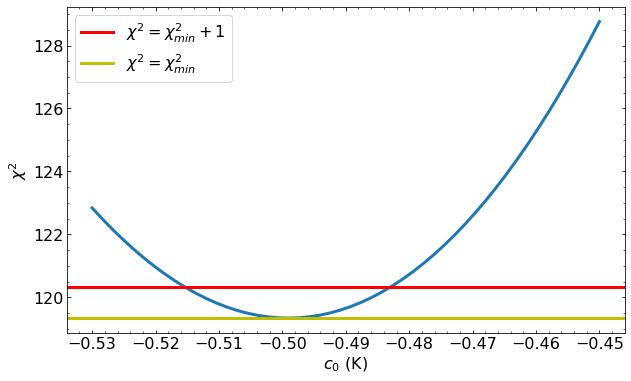

In [131]:
def find_c0_sigma():
    # Find chi squared for the optimal params we found in the earlier part
    optimal_c0 = -0.4990519135532878
    optimal_c1 = 0.7825519185159661
    optimal_c2 = 0.10035803203586494
    optimal_aparams = abest_for_a_params_given_c012(optimal_c0,optimal_c1,optimal_c2)
    optimal_t_fit = np.array(optimal_aparams) @ f_i_for_a_params(scaled_freqs_measured) + optimal_c0 * np.exp(-np.power(np.abs( (scaled_freqs_measured-optimal_c1)/optimal_c2 ), 5) )
    optimal_chisq = np.sum(np.square(optimal_t_fit - temps_measured)) / np.square(0.025)

    c0_within_chisq_min_plus_one = tried_vals_of_c0[resulting_chisquared_from_c0 < optimal_chisq + 1]
    lower_bound = min(c0_within_chisq_min_plus_one)
    upper_bound = max(c0_within_chisq_min_plus_one)
    print("Best c0:",optimal_c0)
    print("Range where chisq < chisq_min+1: {} to {}".format(lower_bound, upper_bound))
    print("One sigma:",(upper_bound-lower_bound)/2)
    
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(tried_vals_of_c0, resulting_chisquared_from_c0)
    ax.set_xlabel(r'$c_0$ (K)')
    ax.set_ylabel(r'$\chi^2$')
    ax.axhline(y=optimal_chisq+1,color='r',label=r'$\chi^2=\chi^2_{min}+1$')
    ax.axhline(y=optimal_chisq,color='y',label=r'$\chi^2=\chi^2_{min}$')
    
    ax.legend()

find_c0_sigma()


We have $\sigma_{c_0}=0.0155$ and $c_{0,best}=-0.49905$, so our signal to noise is $\left|c_{0,best}/\sigma_{c_0}\right|=32.1$. This is close to the signal-to-noise in the paper, which was $37$.

**Part c.** Extra credit: repeat the previous part but drop the assumption that the $1\sigma$ confidence interval corresponds to $\Delta\chi^2=1$. Do this by computing the probability distribution of $c_0$ marginalized over the other seven model parameters. Hint: take fixed values for the nonlinear parameters $c_1$ and $c_2$. If the problem is linear in the remaining six parameters (including $c_0$), what is the likelihood for $c_0$ at these fixed $c_1$ and $c_2$ marginalized over the five $a_i$ (what is its maximum value and what is its functional form)? You can then add these likelihoods for $c_0$ over a large grid of $c_1$ and $c_2$ (but not too large–this computation will be a little bit expensive) and, finally, normalize this marginalized likelihood to compute a new $\sigma$. Compare this to the value you got from $\Delta \chi^2 = 1$.

# Problem 3: Analysis
There are a few serious problems in the preceding analysis. First, we assumed that the errors were uncorrelated between frequencies and simply determined errors by setting $\chi_\text{dof}^2 = 1$. Second, we ignored the fact that we chose a functional form of Equation (4) just to match the data; that parametrization wasn’t physically motivated. Finally, the foreground model we fit was a linearization of a physically motivated model, and the coefficients you derived for the best-fit physical model in part (b) were unrealistic (again, don’t worry about why). In this section you will begin to address these shortcomings.

**Part a.** First, we will deal with the fact that errors are likely to be correlated, for example, that there is some extra foreground or beam correction or something that isn’t in the model but that is correlated bewteen nearby frequencies. The EDGES team has an earlier paper (https://arxiv.org/pdf/1708.05817.pdf), and from fitting the same model from Part 1a to a nearly identical experimental setup at other frequencies (Figure 4 of that paper), I estimate that the covariance might be approximately given by
\begin{equation}
\text{Cov}(T_1,T_2) \approx A\delta_{12} + B\cos\left[\frac{0.3}{\text{MHz}}(\nu_1-\nu_2)\right]\exp\left[-\left|\frac{v_1-v_2}{60\text{MHz}}\right|\right],\tag{5}
\end{equation}
where $\delta_{12}$ is the Dirac delta function; it is one if $\nu_1 = \nu_2$ and zero otherwise. This covariance implies that there is some sinusoidal correlation in the residuals (I do not have great confidence in my particular estimate of the covariance; getting this right is hard and important!). Note that I am now using $\nu$ to represent frequency in MHz rather than a normalized, dimensionless frequency. For the data set
provided from the Nature paper, take $A = (25 mK)^2$ and $B = 2A$ (this is roughly consistent with the earlier data set), and assume this estimate to match the true covariance. In other words, assume that Equation (5) is the true covariance with $A$ and $B$ given above. Construct the covariance matrix for the actual data under these assumptions. Note that in Part 2 we assumed $B = 0$.


**Solution a.**  
Because our covariance matrix is a function of the frequencies for different measurements, we can construct the matrix as a function of $v_1$ and $v_2$, and use numpy's meshgrid to calculate it for all the combinations of frequencies:

In [143]:
def cov_func(v1,v2):
    A = (0.025*0.025)
    B = 2*A
    
    return A*(v1==v2) + B*np.cos(0.3*(v1-v2))*np.exp(-np.abs( (v1-v2)/60 ))
v1_grid, v2_grid = np.meshgrid(freqs_measured, freqs_measured)
Cov = cov_func(v1_grid,v2_grid)

**Part b.** Redo the fit from Part 1a minimizing
\begin{equation}
\chi^2 = (\bf{T}-\bf{m})^\text{T}\bf{C}^{-1}(\bf{T}-\bf{m}) \tag{6}
\end{equation}
rather than the diagonal form you used earlier, and recalculate $\chi^2$. In this expression, $\bf{m}$ is the model, Equation (1), and $\bf{T}$ is the array of measured brightness temperatures. Next, redo Part 2 minimizing this expression for $\chi^2$. It’s still a linear problem in all of the parameters from Equation (1), so you should be able to do this mostly with matrix operations.


**Solution b.**
First we redo the fit from part 1a - We repeat the least squares technique, except we substitute in the appropriate changes that we get from SVD of the covariance matrix. Then, we calculate the resulting chi-squared value of our best fit:

In [160]:

def find_cov_inv():
    U,s,VT = np.linalg.svd(Cov)
    ivar = 1/s
    ivar[s < np.amax(s)*1e-14] = 0
    ivar_full = np.zeros(Cov.T.shape)
    ivar_full[:len(ivar),:len(ivar)] = np.diag(ivar)
    CovInv = U @ ivar_full @ VT
    
    return CovInv

CovInv = find_cov_inv()

def linfit_with_cov_matrix(temps_to_fit):
    U,s,VT = np.linalg.svd(Cov)
    
    Amatrix = linear_fi_funcs(scaled_freqs_measured).T

    Ap = np.dot(U.T, Amatrix)
    bp = np.dot(U.T, temps_to_fit)
    ivar = 1/s
    ivar[s < np.amax(s)*1e-14] = 0
    coef = np.linalg.lstsq(Ap*np.sqrt(ivar[:,np.newaxis]), bp*np.sqrt(ivar),rcond=None)[0]

    pred_t = Amatrix @ coef[:,np.newaxis]
    pred_t = pred_t[:,0] # 1D array

#     fig, ax = plt.subplots(figsize=(10,6))
#     ax.plot(freqs_measured, temps_to_fit - pred_t)
#     ax.set_xlabel(r'$\nu$ (MHz)')
#     ax.set_ylabel(r'$T_{measured}-T_{pred} (K)$')
    
    return coef, pred_t

linfit_coef_with_cov, pred_t_linfit_with_cov = linfit_with_cov_matrix(temps_measured)
    
def chisquared_with_cov(predicted_temps):
    chisquared = (temps_measured - predicted_temps)[np.newaxis,:] @ CovInv @ (temps_measured - predicted_temps)[:,np.newaxis]
    chisquared = chisquared[0][0]
    return chisquared

# print("")
print("Chi squared from linear model with covariance matrix: ", chisquared_with_cov(pred_t_linfit_with_cov))
    

Chi squared from linear model with covariance matrix:  199.79469656860988


Now, we calculate the best fit for our dip, and the error on the best fit for c0:

In [186]:


def get_a_params_for_given_c012_with_cov(c0,c1,c2,c3sqrt=2.2360679775):
    fit_temp_minus_dip = temps_measured - c0*np.exp( - np.power(np.abs( (scaled_freqs_measured-c1)/c2 ),c3sqrt*c3sqrt))
    abest, pred_lhs = linfit_with_cov_matrix(fit_temp_minus_dip)
#     Amatrix = linear_fi_funcs(scaled_freqs_measured).T
    return abest, pred_lhs

def get_best_c12_for_given_c0_with_cov(c0):
#     print("Trying for c0={}".format(c0))
    def chisquared_for_c12(c1and2):
        c1,c2=c1and2
        aparams, pred_linear_temp_part = get_a_params_for_given_c012_with_cov(c0,c1,c2)
        pred_t = pred_linear_temp_part + c0*np.exp( - np.power(np.abs( (scaled_freqs_measured-c1)/c2 ),5))
        return chisquared_with_cov(pred_t)
    
    # Start from several values of c1 c2 to make it more likely that we find the optimal parameters. 
    try_c1_vals = [0.75,0.783,0.8,0.83]
    try_c2_vals = [0.08,0.1,0.12,0.15]
    
    best_c1_overall = None
    best_c2_overall = None
    best_chisquared_overall = None
    
    for ind, start_c1 in enumerate(try_c1_vals):
#         print("c1 ",start_c1)
        for start_c2 in try_c2_vals:
            res=scipy.optimize.minimize(
                chisquared_for_c12,
                [start_c1,start_c2],
                method='Powell',
                bounds=(
                    [0,1],
                    [0,0.4]
                )
            )
            
            if not res.success:
                print("Could not minimize chi squared for c0={},c1={},c2={}".format(cc0,start_c1,start_c2))
                continue
            
            c1_best,c2_best = res.x
            chisquared = chisquared_for_c12([c1_best,c2_best])
            
            if best_chisquared_overall is None or chisquared < best_chisquared_overall:
                best_c1_overall = c1_best
                best_c2_overall = c2_best
                best_chisquared_overall = chisquared
    
    if best_chisquared_overall is None:
        raise Exception("None of the minimize attempts converged")

    return best_c1_overall, best_c2_overall
    
    

We use scipy.optimize.minimize to find the best value of c0 when minimizing chi-squared from the covariance matrix:

In [187]:
def chisquared_with_cov_for_c0(c0arr):
    c0=c0arr[0]
    c1,c2=get_best_c12_for_given_c0_with_cov(c0)
    aparams, pred_linear_temp_part = get_a_params_for_given_c012_with_cov(c0,c1,c2)
    pred_t = pred_linear_temp_part + c0*np.exp( - np.power(np.abs( (scaled_freqs_measured-c1)/c2 ),5))
    return chisquared_with_cov(pred_t)

def find_c0_best():
    
    res = scipy.optimize.minimize(
        chisquared_with_cov_for_c0,
        [-0.5],
        method='Powell',
        bounds=([-1.0,-0.1],)
    )

    if not res.success:
        raise Exception("Could not minimize chi squared for c0")
    
    c0_best = res.x[0]
    return c0_best

c0_best_with_cov = find_c0_best()
print("Best c0 when fitting for covariance is: ", c0_best_with_cov)

Best c0 when fitting for covariance is:  -0.4703328559078912


In [240]:
optimal_chisq_c0= chisquared_with_cov_for_c0([c0_best_with_cov])

Next we can find what the error $\sigma$ is for $c_0$, we can do this by finding the range where $\chi^2 < \chi_{min}^2 + 1$

In [195]:
def find_cov_chisquared_for_c0_range():
    try_c0_vals = np.linspace(-0.52,-0.4,75)
    chisq_vals = []
    print("Finding chisquared for c0 vals ",end="")
    for c0 in try_c0_vals:
        print(".",end="")
        c1,c2 = get_best_c12_for_given_c0_with_cov(c0)
        aparams, pred_linear_temp_part = get_a_params_for_given_c012_with_cov(c0,c1,c2)
        pred_t = pred_linear_temp_part + c0*np.exp( - np.power(np.abs( (scaled_freqs_measured-c1)/c2 ),5))
        chisq_vals.append(chisquared_with_cov(pred_t))

    chisq_vals = np.array(chisq_vals)
    return try_c0_vals, chisq_vals
        
    
try_c0_vals,chisquared_of_c0_vals = find_cov_chisquared_for_c0_range()

Finding chisquared for c0 vals ...........................................................................

Lower and upper bounds on c0 for chisquared < chisquared_best + 1: 
           -0.5157868995310033 , -0.4250447383521678
Sigma for c0: 0.04537108058941777
Signal to noise: 10.366357816427902


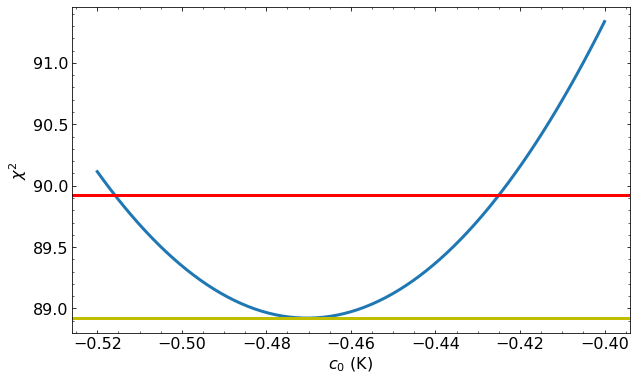

In [241]:
import scipy.interpolate

def find_c0_sigma_with_cov(sample_c0s,sample_chisquared, optimal_chisq, left_size,right_size,log_interp=True):
    
    
    fig, ax = plt.subplots(figsize=(10,6))
    
    ax.plot(sample_c0s, sample_chisquared)
    ax.set_xlabel(r'$c_0$ (K)')
    ax.set_ylabel(r'$\chi^2$')
    ax.axhline(y=optimal_chisq+1,color='r',label=r'$\chi^2=\chi^2_{min}+1$')
    ax.axhline(y=optimal_chisq,color='y',label=r'$\chi^2=\chi^2_{min}$')
    
    # interpolate to find c0 bounds. Interpolating within the strictly decreasing and increasing regions around
    # the intersections with chisquared = chisquared_best + 1
    if log_interp:
        left_bound_chis = sample_chisquared[:left_size]
        left_bound_c0s = sample_c0s[:left_size]
        right_bound_chis = sample_chisquared[-right_size:]
        right_bound_c0s = sample_c0s[-right_size:]
        left_c0_of_chi = scipy.interpolate.interp1d(left_bound_chis,left_bound_c0s)
        right_c0_of_chi = scipy.interpolate.interp1d(right_bound_chis,right_bound_c0s)
        left_bound = left_c0_of_chi(optimal_chisq+1)
        right_bound = right_c0_of_chi(optimal_chisq+1)
        print("Lower and upper bounds on c0 for chisquared < chisquared_best + 1: ")
        print("          ",left_bound,",",right_bound)
        sigma = (right_bound - left_bound)/2
        print("Sigma for c0:", sigma)
        print("Signal to noise:", abs(c0_best_with_cov/sigma))

#     interpolated_left = 
find_c0_sigma_with_cov(try_c0_vals,chisquared_of_c0_vals,optimal_chisq_c0, 20,40)

This looks like a decent signal-to-noise, but not as good as before.

**Part c.**
Now redo the fit from Part 2 with the full covariance matrix. Furthermore, let one additional parameter float: the exponent inside the exponential of Equation (4). To avoid letting the exponent be negativeyou can write it as $(\sqrt{c_3})^2$ and optimize $\sqrt{c_3}$. Your fit should end up being linear in all but three parameters now, so you’ll want to combine nonlinear optimization in those three with a linear fit at each set of values of those three. What is your best-fit amplitude $c_0$ now, and what is its standard error (derived from $\chi^2 = \chi_\text{min}^2 + 1$)? How many sigma is the detection under these assumptions?

**Solution c.**
This time we do the same as before, but we minimize with respect to our $\sqrt{c_3}$ parameter too.

In [277]:

def get_a_params_for_given_c0123_with_cov(c0,c1,c2,c3):
    fit_temp_minus_dip = temps_measured - c0*np.exp( - np.power(np.abs( (scaled_freqs_measured-c1)/c2 ),c3*c3))
    abest, pred_lhs = linfit_with_cov_matrix(fit_temp_minus_dip)
#     Amatrix = linear_fi_funcs(scaled_freqs_measured).T
    return abest, pred_lhs


def get_best_c123_for_given_c0_with_cov(c0):
    def chisquared_for_c123(c1and2and3):
        c1,c2,c3=c1and2and3
        aparams, pred_linear_temp_part = get_a_params_for_given_c0123_with_cov(c0,c1,c2,c3)
        pred_t = pred_linear_temp_part + c0*np.exp( - np.power(np.abs( (scaled_freqs_measured-c1)/c2 ),c3*c3))
        return chisquared_with_cov(pred_t)
    
    # Start from several values of c1 c2 to make it more likely that we find the optimal parameters. 
#     0.9438834563394398 0.2626530621568062 3.530184713178291
#     try_c1_vals = np.linspace(0.77,0.8,1)
#     try_c2_vals = np.linspace(0.9,1.1,2)
#     try_c3_vals = np.linspace(1.5,3,2)
    try_c1_vals = [0.7809571318981562]
    try_c2_vals = [0.09982167461477756]
    try_c3_vals = [2.023423563942696]
    
    best_c1_overall = None
    best_c2_overall = None
    best_c3_overall = None
    best_chisquared_overall = None
    
    for start_c1 in try_c1_vals:
#         print("try start c1",start_c1)
        for start_c2 in try_c2_vals:
            for start_c3 in try_c3_vals:
                res=scipy.optimize.basinhopping(
                    chisquared_for_c123,
                    [start_c1,start_c2,start_c3],
#                     method='Powell',
#                     bounds=(
#                         [0,1],
#                         [0.001,0.4],
#                         [1,50]
#                     )
                )

#                 if not res.success:
#                     print("Could not minimize chi squared for c0={},c1={},c2={},c3={}".format(c0,start_c1,start_c2,start_c3))
#                     continue

                c1_best,c2_best,c3_best = res.x
                chisquared = chisquared_for_c123([c1_best,c2_best,c3_best])

                if best_chisquared_overall is None or chisquared < best_chisquared_overall:
                    best_c1_overall = c1_best
                    best_c2_overall = c2_best
                    best_c3_overall = c3_best
                    best_chisquared_overall = chisquared
    
    if best_chisquared_overall is None:
        raise Exception("None of the minimize attempts converged")

    return best_c1_overall, best_c2_overall, best_c3_overall
    

In [283]:
def find_cov_chisquared_for_c0_range_with_c3():
#     try_c0_vals_withc3 = [-0.583]
    try_c0_vals_withc3 = np.linspace(-0.9,-0.2,20)
    chisq_vals = []
    print("Finding chisquared for c0 vals ",end="")
    for c0 in try_c0_vals_withc3:
        print(".",end="")
        c1,c2,c3 = get_best_c123_for_given_c0_with_cov(c0)
        print("c0 and c1,c2,c3:")
        print(c0,c1,c2,c3)

        aparams, pred_linear_temp_part = get_a_params_for_given_c0123_with_cov(c0,c1,c2,c3)
        pred_t = pred_linear_temp_part + c0*np.exp( - np.power(np.abs( (scaled_freqs_measured-c1)/c2 ),c3*c3))
        chisq_vals.append(chisquared_with_cov(pred_t))
    print("")
    chisq_vals = np.array(chisq_vals)
    return try_c0_vals_withc3, chisq_vals
        
    
try_c0_vals_withc3,chisquared_of_c0_vals_withc3 = find_cov_chisquared_for_c0_range_with_c3()

Finding chisquared for c0 vals .

<ipython-input-277-693d4ad4b343>:2: RuntimeWarning: overflow encountered in power
  fit_temp_minus_dip = temps_measured - c0*np.exp( - np.power(np.abs( (scaled_freqs_measured-c1)/c2 ),c3*c3))
<ipython-input-277-693d4ad4b343>:12: RuntimeWarning: overflow encountered in power
  pred_t = pred_linear_temp_part + c0*np.exp( - np.power(np.abs( (scaled_freqs_measured-c1)/c2 ),c3*c3))
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:1166: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (np.dot(yk, sk))
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:1166: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (np.dot(yk, sk))
<ipython-input-277-693d4ad4b343>:2: RuntimeWarning: overflow encountered in power
  fit_temp_minus_dip = temps_measured - c0*np.exp( - np.power(np.abs( (scaled_freqs_measured-c1)/c2 ),c3*c3))
<ipython-input-277-693d4ad4b343>:12: RuntimeWarning: overflow encountered in power
  pred_

c0 and c1,c2,c3:
-0.9 0.7825966595426909 0.10239643099828287 1.8312161982015274
.

<ipython-input-277-693d4ad4b343>:2: RuntimeWarning: overflow encountered in power
  fit_temp_minus_dip = temps_measured - c0*np.exp( - np.power(np.abs( (scaled_freqs_measured-c1)/c2 ),c3*c3))
<ipython-input-277-693d4ad4b343>:12: RuntimeWarning: overflow encountered in power
  pred_t = pred_linear_temp_part + c0*np.exp( - np.power(np.abs( (scaled_freqs_measured-c1)/c2 ),c3*c3))


c0 and c1,c2,c3:
-0.8631578947368421 0.7822717511239282 0.10192219050637057 1.8500344784996046
.

<ipython-input-277-693d4ad4b343>:2: RuntimeWarning: overflow encountered in power
  fit_temp_minus_dip = temps_measured - c0*np.exp( - np.power(np.abs( (scaled_freqs_measured-c1)/c2 ),c3*c3))
<ipython-input-277-693d4ad4b343>:12: RuntimeWarning: overflow encountered in power
  pred_t = pred_linear_temp_part + c0*np.exp( - np.power(np.abs( (scaled_freqs_measured-c1)/c2 ),c3*c3))
<ipython-input-277-693d4ad4b343>:2: RuntimeWarning: overflow encountered in power
  fit_temp_minus_dip = temps_measured - c0*np.exp( - np.power(np.abs( (scaled_freqs_measured-c1)/c2 ),c3*c3))
<ipython-input-277-693d4ad4b343>:12: RuntimeWarning: overflow encountered in power
  pred_t = pred_linear_temp_part + c0*np.exp( - np.power(np.abs( (scaled_freqs_measured-c1)/c2 ),c3*c3))
<ipython-input-277-693d4ad4b343>:2: RuntimeWarning: overflow encountered in power
  fit_temp_minus_dip = temps_measured - c0*np.exp( - np.power(np.abs( (scaled_freqs_measured-c1)/c2 ),c3*c3))
<ipython-input-277-693d4ad4b343>:12: RuntimeWarn

c0 and c1,c2,c3:
-0.8263157894736842 0.7819914126580021 0.10152070218742254 1.8697052249114905
.

<ipython-input-277-693d4ad4b343>:2: RuntimeWarning: overflow encountered in power
  fit_temp_minus_dip = temps_measured - c0*np.exp( - np.power(np.abs( (scaled_freqs_measured-c1)/c2 ),c3*c3))
<ipython-input-277-693d4ad4b343>:12: RuntimeWarning: overflow encountered in power
  pred_t = pred_linear_temp_part + c0*np.exp( - np.power(np.abs( (scaled_freqs_measured-c1)/c2 ),c3*c3))
<ipython-input-277-693d4ad4b343>:2: RuntimeWarning: overflow encountered in power
  fit_temp_minus_dip = temps_measured - c0*np.exp( - np.power(np.abs( (scaled_freqs_measured-c1)/c2 ),c3*c3))
<ipython-input-277-693d4ad4b343>:12: RuntimeWarning: overflow encountered in power
  pred_t = pred_linear_temp_part + c0*np.exp( - np.power(np.abs( (scaled_freqs_measured-c1)/c2 ),c3*c3))
<ipython-input-277-693d4ad4b343>:2: RuntimeWarning: overflow encountered in power
  fit_temp_minus_dip = temps_measured - c0*np.exp( - np.power(np.abs( (scaled_freqs_measured-c1)/c2 ),c3*c3))
<ipython-input-277-693d4ad4b343>:12: RuntimeWarn

c0 and c1,c2,c3:
-0.7894736842105263 0.7817472167480378 -0.10117186149926442 1.8904368289797548
.

<ipython-input-277-693d4ad4b343>:2: RuntimeWarning: overflow encountered in power
  fit_temp_minus_dip = temps_measured - c0*np.exp( - np.power(np.abs( (scaled_freqs_measured-c1)/c2 ),c3*c3))
<ipython-input-277-693d4ad4b343>:12: RuntimeWarning: overflow encountered in power
  pred_t = pred_linear_temp_part + c0*np.exp( - np.power(np.abs( (scaled_freqs_measured-c1)/c2 ),c3*c3))
<ipython-input-277-693d4ad4b343>:2: RuntimeWarning: overflow encountered in power
  fit_temp_minus_dip = temps_measured - c0*np.exp( - np.power(np.abs( (scaled_freqs_measured-c1)/c2 ),c3*c3))
<ipython-input-277-693d4ad4b343>:12: RuntimeWarning: overflow encountered in power
  pred_t = pred_linear_temp_part + c0*np.exp( - np.power(np.abs( (scaled_freqs_measured-c1)/c2 ),c3*c3))
<ipython-input-277-693d4ad4b343>:2: RuntimeWarning: overflow encountered in power
  fit_temp_minus_dip = temps_measured - c0*np.exp( - np.power(np.abs( (scaled_freqs_measured-c1)/c2 ),c3*c3))
<ipython-input-277-693d4ad4b343>:12: RuntimeWarn

c0 and c1,c2,c3:
-0.7526315789473684 0.7815358641941424 -0.1008630822039361 1.9124438451369095
.

<ipython-input-277-693d4ad4b343>:2: RuntimeWarning: overflow encountered in power
  fit_temp_minus_dip = temps_measured - c0*np.exp( - np.power(np.abs( (scaled_freqs_measured-c1)/c2 ),c3*c3))
<ipython-input-277-693d4ad4b343>:12: RuntimeWarning: overflow encountered in power
  pred_t = pred_linear_temp_part + c0*np.exp( - np.power(np.abs( (scaled_freqs_measured-c1)/c2 ),c3*c3))
<ipython-input-277-693d4ad4b343>:2: RuntimeWarning: overflow encountered in power
  fit_temp_minus_dip = temps_measured - c0*np.exp( - np.power(np.abs( (scaled_freqs_measured-c1)/c2 ),c3*c3))
<ipython-input-277-693d4ad4b343>:12: RuntimeWarning: overflow encountered in power
  pred_t = pred_linear_temp_part + c0*np.exp( - np.power(np.abs( (scaled_freqs_measured-c1)/c2 ),c3*c3))
<ipython-input-277-693d4ad4b343>:2: RuntimeWarning: overflow encountered in power
  fit_temp_minus_dip = temps_measured - c0*np.exp( - np.power(np.abs( (scaled_freqs_measured-c1)/c2 ),c3*c3))
<ipython-input-277-693d4ad4b343>:12: RuntimeWarn

c0 and c1,c2,c3:
-0.7157894736842105 0.7813531964872906 0.10058360097495753 1.935973136957692
.

<ipython-input-277-693d4ad4b343>:2: RuntimeWarning: overflow encountered in power
  fit_temp_minus_dip = temps_measured - c0*np.exp( - np.power(np.abs( (scaled_freqs_measured-c1)/c2 ),c3*c3))
<ipython-input-277-693d4ad4b343>:12: RuntimeWarning: overflow encountered in power
  pred_t = pred_linear_temp_part + c0*np.exp( - np.power(np.abs( (scaled_freqs_measured-c1)/c2 ),c3*c3))
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:1166: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (np.dot(yk, sk))
<ipython-input-277-693d4ad4b343>:2: RuntimeWarning: overflow encountered in power
  fit_temp_minus_dip = temps_measured - c0*np.exp( - np.power(np.abs( (scaled_freqs_measured-c1)/c2 ),c3*c3))
<ipython-input-277-693d4ad4b343>:12: RuntimeWarning: overflow encountered in power
  pred_t = pred_linear_temp_part + c0*np.exp( - np.power(np.abs( (scaled_freqs_measured-c1)/c2 ),c3*c3))


c0 and c1,c2,c3:
-0.6789473684210527 0.7811987366134787 -0.10032637325721817 1.961331670551163
.

<ipython-input-277-693d4ad4b343>:2: RuntimeWarning: overflow encountered in power
  fit_temp_minus_dip = temps_measured - c0*np.exp( - np.power(np.abs( (scaled_freqs_measured-c1)/c2 ),c3*c3))
<ipython-input-277-693d4ad4b343>:12: RuntimeWarning: overflow encountered in power
  pred_t = pred_linear_temp_part + c0*np.exp( - np.power(np.abs( (scaled_freqs_measured-c1)/c2 ),c3*c3))
<ipython-input-277-693d4ad4b343>:2: RuntimeWarning: overflow encountered in power
  fit_temp_minus_dip = temps_measured - c0*np.exp( - np.power(np.abs( (scaled_freqs_measured-c1)/c2 ),c3*c3))
<ipython-input-277-693d4ad4b343>:12: RuntimeWarning: overflow encountered in power
  pred_t = pred_linear_temp_part + c0*np.exp( - np.power(np.abs( (scaled_freqs_measured-c1)/c2 ),c3*c3))
<ipython-input-277-693d4ad4b343>:2: RuntimeWarning: overflow encountered in power
  fit_temp_minus_dip = temps_measured - c0*np.exp( - np.power(np.abs( (scaled_freqs_measured-c1)/c2 ),c3*c3))
<ipython-input-277-693d4ad4b343>:12: RuntimeWarn

c0 and c1,c2,c3:
-0.6421052631578947 0.7810707910695354 -0.10008436514822042 1.988829735866415
.

<ipython-input-277-693d4ad4b343>:2: RuntimeWarning: overflow encountered in power
  fit_temp_minus_dip = temps_measured - c0*np.exp( - np.power(np.abs( (scaled_freqs_measured-c1)/c2 ),c3*c3))
<ipython-input-277-693d4ad4b343>:12: RuntimeWarning: overflow encountered in power
  pred_t = pred_linear_temp_part + c0*np.exp( - np.power(np.abs( (scaled_freqs_measured-c1)/c2 ),c3*c3))


KeyboardInterrupt: 

In [280]:
print(chisquared_of_c0_vals_withc3)

[86.78833238 86.76785424 86.74861602 86.73062285 86.71387986 86.69839223
 86.68416513 86.67120379 86.65951375 86.64909976 86.63996776 86.632123
 86.62557102 86.62031726 86.61636707 86.61372629 86.61240081 86.6123958
 86.61371748 86.61637155]


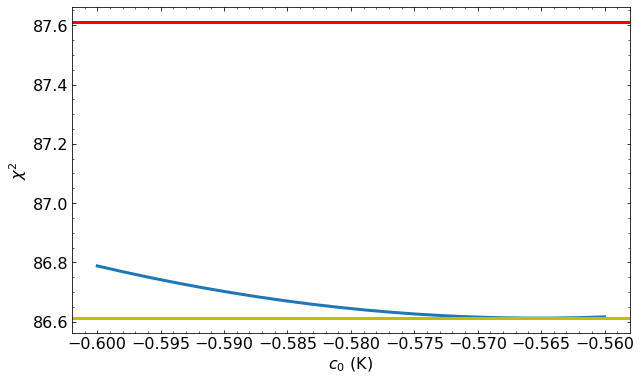

In [281]:
 
find_c0_sigma_with_cov(try_c0_vals_withc3,chisquared_of_c0_vals_withc3, chisquared_of_c0_vals_withc3.min(), 20,40,log_interp=False)

It appears that with this change, the error of $c_0$ goes way out. I wasn't able to get a sensible value for $\sigma$.

**Part d.** Note that the model still is not physical, and a physically motivated model would produce a vastly inferior fit to this one. Try an exponent of 2 in Equation (4), just for fun, if you have the time. This is probably what the team fit to their data first before they went looking for models that fit better (maybe there should be a trials factor penalty here that we haven’t even assessed yet). What is the best-fit value of $c_0$ and what is its standard error, using the full covariance matrix for the data?